# **Gaussian Mixture Model using Expectation Maximization Algorithm for Soft Clustering**

### **Gaussian Mixture Model**

**Definition:**
- A Gaussian Mixture is a function that is comprised of several Gaussians, each identified by k ∈ {1,…, K}, where K is the number of clusters of our dataset. Each Gaussian k in the mixture is comprised of the following parameters:

  - A mean μ that defines its centre.
  - A covariance Σ that defines its width. This would be equivalent to the dimensions of an ellipsoid in a multivariate scenario.
  - A mixing probability π that defines how big or small the Gaussian function will be.

The mixing coefficients are themselves probabilities and must meet this condition:
$$
\sum_{k=1}^{K} \pi_{k}=1
$$

To achieve optimal values for the parameters, we must ensure that **each Gaussian fits the data points belonging to each cluster**. This is exactly what maximum likelihood does.

$$$$


### **Gaussian Density Function**

The Multivariate Gaussian Density function is given by: 

##$$
p(\mathbf{x} \mid \mu, \boldsymbol{\Sigma})=\frac{1}{(2 \pi)^{D / 2}|\Sigma|^{1 / 2}} \exp \left(-\frac{1}{2}(\mathbf{x}-\mu)^{T} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\mu)\right)
$$

where, $\mathbf{x}$ represents our data points, D is the number of dimensions of each data point. μ and Σ are the mean and covariance, respectively. 

$$$$

For example, if the dataset is comprised of N = 1000 three-dimensional points (D = 3), then 
  - x will be a 1000 × 3 matrix 
  - μ will be a 1 × 3 vector, and 
  - Σ will be a 3 × 3 matrix.

$$$$

The **Log of the Multivariate Gaussian Density Function** is given by: 

##$$
\ln \mathcal{N}(\mathbf{x} \mid \mu, \Sigma)=-\frac{D}{2} \ln 2 \pi-\frac{1}{2} \ln \Sigma-\frac{1}{2}(\mathbf{x}-\mu)^{T} \Sigma^{-1}(\mathbf{x}-\mu)
$$

$$$$

Differentiating the above equation with respect to the mean and covariance and then equate it to zero, then we will be able to find the optimal values for these parameters, and the solutions will correspond to the **Maximum Likelihood Estimates (MLE)** for this setting. However, because we are dealing with not just one, but many Gaussians, things will get a bit complicated when time comes for us to find the parameters for the whole mixture.

$$$$

### **Initial Derivations**

First, let’s suppose we want to know what is the probability that a data point $\mathbf{x_n}$ comes from Gaussian $k$. We can express this as:

##$$
p\left(z_{n k}=1 \mid \mathbf{x}_{n}\right)
$$

The above equation reads as "*given a data point x, what is the probability it came from Gaussian k?*"

In this case, $z$ is a latent variable that takes only two possible values. It is one when x came from Gaussian k, and zero otherwise. Actually, we don’t get to see this z variable in reality, but knowing its probability of occurrence will be useful in helping us determine the Gaussian mixture parameters.

$$$$

Likewise, we can state the following:

##$$
\pi_{k}=p\left(z_{k}=1\right)
$$

which means <u>the overall probability of observing a point that comes from Gaussian $k$ is actually equivalent to the mixing coefficient for that Gaussian</u>. This makes sense, because the bigger the Gaussian is, the higher we would expect this probability to be. Now let $\mathbf{z}$ be the set of all possible latent variables ${z}$, hence:

##$$
\mathbf{z}=\left\{z_{1}, \ldots, z_{K}\right\}
$$


We know beforehand that each $z$ occurs independently of others and that they can only take the value of one when $k$ is equal to the cluster the point comes from. Therefore:

##$$
p(\mathbf{z})=p\left(z_{1}=1\right)^{z_{1}} p\left(z_{2}=1\right)^{z_{2}} \ldots p\left(z_{K}=1\right)^{z_{K}}=\prod_{k=1}^{K} \pi_{k}^{z_{k}}
$$

$$$$

Now, what about finding the probability of observing our data given that it came from Gaussian $k$? Turns out to be that it is actually the Gaussian function itself! Following the same logic we used to define $p(z)$, we can state:

##$$
p\left(\mathbf{x}_{n} \mid \mathbf{z}\right)=\prod_{k=1}^{K} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)^{z_{k}}
$$


The initial aim was to **determine what the probability of $z$ given our observation $x$** ? Well, it turns out to be that the equations we have just derived, along with the Bayes rule, will help us determine this probability. From the product rule of probabilities, we know that

##$$
p\left(\mathbf{x}_{n}, \mathbf{z}\right)=p\left(\mathbf{x}_{n} \mid \mathbf{z}\right) p(\mathbf{z})
$$

Hmm, it seems to be that now we are getting somewhere. The operands on the right are what we have just found. Perhaps some of you may be anticipating that we are going to use the Bayes rule to get the probability we eventually need. However, first we will need $p(x_n)$, not $p(x_n, z)$. So how do we get rid of $z$ here? Yes, you guessed it right. Marginalization! We just need to sum up the terms on z, hence

##$$
p\left(\mathbf{x}_{n}\right)=\sum_{k=1}^{K} p\left(\mathbf{x}_{n} \mid \mathbf{z}\right) p(\mathbf{z})=\sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)
$$

$$$$

<u>This is the equation that defines a Gaussian Mixture, and you can clearly see that it depends on all parameters that we mentioned previously!</u>

**To determine the optimal values for these we need to determine the maximum likelihood of the model. We can find the likelihood as the joint probability of all observations $x_n$, defined by**:

##$$
p(\mathbf{X})=\prod_{n=1}^{N} p\left(\mathbf{X}_{n}\right)=\prod_{n=1}^{N} \sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)
$$

$$$$

Like we did for the original Gaussian density function, let's apply the log to each side of the equation:

##$$
\ln p(\mathbf{X})=\sum_{n=1}^{N} \ln \sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)
$$


In order to find the optimal parameters for the Gaussian mixture, all we have to do is to differentiate this equation with respect to the parameters and we are done, right? Wait! Not so fast. We have an issue here. We can see that there is a logarithm that is affecting the second summation. Calculating the derivative of this expression and then solving for the parameters is going to be very hard!

$$$$

What can we do? Well, we need to use an iterative method to estimate the parameters. But first, remember we were supposed to find the probability of $z$ given $\mathrm{x}$ ? Well, let's do that since at this point we already have everything in place to define what this probability will look like.

$$$$

From Bayes rule, we know that
##$$
p\left(z_{k}=1 \mid \mathbf{x}_{n}\right)=\frac{p\left(\mathbf{x}_{n} \mid z_{k}=1\right) p\left(z_{k}=1\right)}{\sum_{j=1}^{K} p\left(\mathbf{x}_{n} \mid z_{j}=1\right) p\left(z_{j}=1\right)}
$$

$$$$

From our earlier derivations we learned that:

##$$
p\left(z_{k}=1\right)=\pi_{k}, \quad p\left(\mathbf{x}_{n} \mid z_{k}=1\right)=\mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)
$$

$$$$

So let's now replace these in the previous equation:

##$$
p\left(z_{k}=1 \mid \mathbf{x}_{n}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{j}, \Sigma_{j}\right)}=\gamma\left(z_{n k}\right)
$$


And this is what we've been looking forl Moving forward we are going to see this expression a lot. Next we will continue our discussion with a method that will help us easily determine the parameters for the Gaussian mixture.

$$$$

$$$$

### **Expectation Maximization**

Well, at this point we have derived some expressions for the probabilities that we will find useful in determining the parameters of our model. However, in the past section we could see that simply evaluating 

##$$
\ln p(\mathbf{X})=\sum_{n=1}^{N} \ln \sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)
$$


to find such parameters would prove to be very hard. 

$$$$


Fortunately, there is an iterative method we can use to achieve this purpose. It is called the Expectation - Maximization, or simply EM algorithm. It is widely used for optimization problems where the objective function has complexities such as the one we've just encountered for the GMM case.

Let the parameters of our model be

##$$
\theta=\{\pi, \mu, \Sigma\}
$$

$$$$


Let us now define the steps that the general EM algorithm will follow.

#### **Step 1 (Initialization)**: 
Initialise $\theta$ accordingly. For instance, we can use the results obtained by a previous K-Means run as a good starting point for our algorithm.

$$$$

$$$$

#### **Step 2 (Expectation step)**: Evaluate

##$$
\mathcal{Q}\left(\theta^{*}, \theta\right)=\mathbb{E}\left[\ln p\left(\mathbf{X}, \mathbf{Z} \mid \theta^{*}\right)\right]=\sum_{\mathbf{Z}} p(\mathbf{Z} \mid \mathbf{X}, \theta) \ln p\left(\mathbf{X}, \mathbf{Z} \mid \theta^{*}\right)
$$


Well, actually we have already found $p(\mathrm{Z} \mid \mathrm{X}, \theta)$. Remember the $y$ expression we ended up with in the previous section? For better visibility, let's bring our earlier equation (4) here:

##$$
p\left(z_{k}=1 \mid \mathbf{x}_{n}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{j}, \Sigma_{j}\right)}=\gamma\left(z_{n k}\right)
$$

For Gaussian Mixture Models, the expectation step boils down to calculating the value of $y$ in (4) by using the old parameter values. Now if we replace (4) in (5), we will have:


##$$
\mathcal{Q}\left(\theta^{*}, \theta\right)=\sum_{\mathbf{Z}} \gamma\left(z_{n k}\right) \ln p\left(\mathbf{X}, \mathbf{Z} \mid \theta^{*}\right)
$$


Sounds good, but we are still missing $p\left(\mathrm{X}, \mathrm{Z} \mid \theta^{*}\right)$. How can we find it? Well, actually it's not that difficult. It is just the complete likelihood of the model, including both $\mathrm{X}$ and $\mathrm{Z}$, and we can find it by using the following expression:


##$$
p\left(\mathbf{X}, \mathbf{Z} \mid \theta^{*}\right)=\prod_{n=1}^{N} \prod_{k=1}^{K} \pi^{z_{n k}} \mathcal{N}\left(\mathbf{X}_{n} \mid \mu_{k}, \Sigma_{k}\right)^{z_{n k}}
$$


Which is the result of calculating the joint probability of all observations and latent variables and is an extension of our initial derivations for $p(\mathrm{x})$. The log of this expression is given by


##$$
\ln p\left(\mathbf{X}, \mathbf{Z} \mid \theta^{*}\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} z_{n k}\left[\ln \pi_{k}+\ln \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)\right]
$$


Nice! And we have finally gotten rid of this troublesome logarithm that affected the summation in (3). With all of this in place, it will be much easier for us to estimate the parameters by just maximizing $Q$ with respect to the parameters, but we will deal with this in the maximization step. Besides, remember that the latent variable $z$ will only be 1 once everytime the summation is evaluated. With that knowledge, we can easily get rid of it as needed for our derivations.


Finally, we can replace (7) in (6) to get:

##$$
\mathcal{Q}\left(\theta^{*}, \theta\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} \gamma\left(z_{n k}\right)\left[\ln \pi_{k}+\ln \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)\right]
$$

Nice! And we have finally gotten rid of this troublesome logarithm that affected the summation in (3). With all of this in place, it will be much easier for us to estimate the parameters by just maximizing $Q$ with respect to the parameters, but we will deal with this in the maximization step. Besides, remember that the latent variable $z$ will only be 1 once everytime the summation is evaluated. With that knowledge, we can easily get rid of it as needed for our derivations.

Finally, we can replace (7) in (6) to get:

##$$
\mathcal{Q}\left(\theta^{*}, \theta\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} \gamma\left(z_{n k}\right)\left[\ln \pi_{k}+\ln \mathcal{N}\left(\mathrm{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)\right]
$$

In the maximization step, we will find the revised parameters of the mixture. For this purpose, we will need to make $Q$ a restricted maximization problem and thus we will add a Lagrange multiplier to (8). Let's now review the maximization step.

$$$$

$$$$

#### **Step 3 (Maximization step):**  Find the revised parameters $\theta^{*}$ using:

##$$
\theta^{*}=\arg \max _{\theta} \mathcal{Q}\left(\theta^{*}, \theta\right)
$$

where

##$$
\mathcal{Q}\left(\theta^{*}, \theta\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} \gamma\left(z_{n k}\right)\left[\ln \pi_{k}+\ln \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)\right]
$$

Which is what we ended up with in the previous step. However, Q should also take into account the restriction that all $\pi$ values should sum up to one. To do so, we will need to add a suitable Lagrange multiplier. Therefore, we should rewrite (8) in this way:

##$$
\mathcal{Q}\left(\theta^{*}, \theta\right)=\sum_{n=1}^{N} \sum_{k=1}^{K} \gamma\left(\tau_{n k}\right)\left[\ln \pi_{k}+\ln \mathcal{N}\left(x_{n} \mid \mu_{k}, \Sigma_{k}\right)\right]-\lambda\left(\sum_{k=1}^{K} \pi_{k}-1\right)
$$

And now we can easily determine the parameters by using maximum likelihood. Let's now take the derivative of $Q$ with respect to $\pi$ and set it equal to zero:

##$$
\frac{\partial \mathcal{Q}\left(\theta^{*}, \theta\right)}{\partial \pi_{k}}=\sum_{n=1}^{N} \frac{\gamma\left(z_{n k}\right)}{\pi_{k}}-\lambda=0
$$

Then, by rearranging the terms and applying a summation over $k$ to both sides of the equation, we obtain:

##$$
\sum_{n=1}^{N} \gamma\left(z_{n k}\right)=\pi_{k} \lambda \Longrightarrow \sum_{k=1}^{K} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)=\sum_{k=1}^{K} \pi_{k} \lambda
$$

From (1), we know that the summation of all mixing coefficients $\pi$ equals one. In addition, we know that summing up the probabilities y over $k$ will also give us $1 .$ Thus we get $\lambda=N$. Using this result, we can solve for $\pi$ :

##$$
\pi_{k}=\frac{\sum_{n=1}^{N} \gamma\left(z_{n k}\right)}{N}
$$

Similarly, if we differentiate $Q$ with respect to $\mu$ and $\Sigma$, equate the derivative to zero and then solve for the parameters by making use of the log-likelihood equation (2) we defined, we obtain:

##$$
\mu_{k}^{*}=\frac{\sum_{n=1}^{N} \gamma\left(z_{n k}\right) \mathbf{x}_{n}}{\sum_{n=1}^{N} \gamma\left(z_{n k}\right)}, \quad \Sigma_{k}^{*}=\frac{\sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(\mathbf{x}_{n}-\mu_{k}\right)\left(\mathbf{x}_{n}-\mu_{k}\right)^{T}}{\sum_{n=1}^{N} \gamma\left(z_{n k}\right)}
$$

And that’s it! Then we will use these revised values to determine γ in the next EM iteration and so on and so forth until we see some convergence in the likelihood value. We can use equation (3) to monitor the log-likelihood in each step and we are always guaranteed to reach a local maximum.


In [1]:
import sklearn
from sklearn import datasets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.cluster
from matplotlib.patches import Ellipse
import matplotlib.colors as colors

# Load the IRIS Dataset

In [2]:
iris = sns.load_dataset("iris")
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [3]:
iris_np = datasets.load_iris()
X = iris_np.data 
Y = iris_np.target 
(data_size, dimension) = X.shape
print("Data Size: {} and Dimension: {}".format(data_size, dimension))

Data Size: 150 and Dimension: 4


# Visualizing Train Dataset

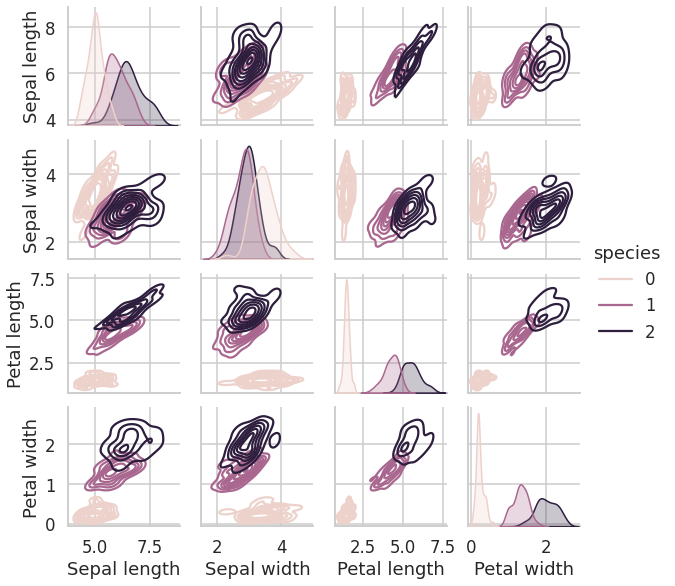

In [4]:
labeled_data_df = pd.DataFrame({"Sepal length":X[:,0], 
                                "Sepal width":X[:,1], 
                                "Petal length":X[:,2], 
                                "Petal width":X[:,3], 
                                "species":Y})
sns.set_style("whitegrid")
sns.set_context("talk")
sns.pairplot(labeled_data_df, vars=["Sepal length",
                                    "Sepal width",
                                    "Petal length",
                                    "Petal width"], 
            kind="kde", hue="species", markers=["o", "s", "D"], height = 2.1)
plt.show()

## **Gaussian Mixture Model Implementation**

Multivariate Gaussian Distribution is mathematically expressed as

$$
p(\mathbf{x} \mid \mu, \boldsymbol{\Sigma})=\frac{1}{(2 \pi)^{n / 2}|\Sigma|^{1 / 2}} \exp \left(-\frac{1}{2}(\mathbf{x}-\mu)^{T} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\mu)\right)
$$

In [5]:
def GaussianDistribution(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    den = 1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5)
    num = np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))
    return np.diagonal(den * num).reshape(-1, 1)

### **Initialization**

In [6]:
def Initialization(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    kmeans = sklearn.cluster.KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

### **E-Step (Expectation Step)**

- Start with cluster mean $\mu_{k}$, covariance $\mathbf{\Sigma}_{k}$ and $\pi_{k}$
- E-Step
  - for each data point compute $\gamma\left(z_{n k}\right)$ that belongs to the cluster

$$
\gamma\left(z_{n k}\right)=\frac{\pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \mathbf{\Sigma}_{k}\right)}{\sum_{j=1}^{K} \pi_{j} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{j}, \boldsymbol{\Sigma}_{j}\right)}
$$

In [7]:
def EStep(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * GaussianDistribution(X, mu_k, cov_k)).ravel()
        
    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)

### **M-Step (Maximization Step):**

Let us now implement the maximization step. Since $\gamma\left(z_{n k}\right)$ is common to the expressions for $\pi_{k}, \mu_{k}$ and $\Sigma_{k}$, we can simply define:
$$
N_{k}=\sum_{n=1}^{N} \gamma\left(z_{n k}\right)
$$
And then we can calculate the revised parameters by using:
$$
\begin{array}{c}
\pi_{k}^{*}=\frac{N_{k}}{N} \\
\mu_{k}^{*}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right) \mathbf{x}_{n} \\
\Sigma_{k}^{*}=\frac{1}{N_{k}} \sum_{n=1}^{N} \gamma\left(z_{n k}\right)\left(\mathbf{x}_{n}-\mu_{k}\right)\left(\mathbf{x}_{n}-\mu_{k}\right)^{T}
\end{array}
$$
Note: To calculate the covariance, we define an auxiliary variable diff that contains $\left(x_{n}-\mu_{k}\right)^{T}$.

In [8]:
def MStep(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

### **Likelihood Estimation**

Let us now determine the log-likelihood of the model. It is given by:

$$
\ln p(\mathbf{X})=\sum_{n=1}^{N} \ln \sum_{k=1}^{K} \pi_{k} \mathcal{N}\left(\mathbf{x}_{n} \mid \mu_{k}, \Sigma_{k}\right)
$$

However, the second summation has already been calculated in the expectation_step function and is available in the totals variable. So we just make use it.

In [9]:
def Likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

In [12]:
def train(X, n_clusters, n_epochs):
    clusters = Initialization(X, n_clusters)
    likelihoods = []
    history = []
    likelihood_prev = np.Infinity
    likelihood = 0
    thres = 1e-6
    print("----------------------------------------------")
    print("               Training Summary               ")
    print("----------------------------------------------")

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
        EStep(X, clusters)
        MStep(X, clusters)

        likelihood, sample_likelihoods = Likelihood(X, clusters)
        likelihoods.append(likelihood)

        print('Epoch: \t', i + 1, '\tLikelihood: \t %.6f' %likelihood)
        if np.abs(likelihood_prev - likelihood) < thres:
            print("\nEarly Stopping Enabled!! Training Stopped")
            print("----------------------------------------------")
            break
        likelihood_prev = likelihood

    scores = np.log(gamma_nk)
    likelihoods = np.asarray(likelihoods)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

In [13]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train(X, 
                                                                   n_clusters, 
                                                                   n_epochs)

----------------------------------------------
               Training Summary               
----------------------------------------------
Epoch: 	 1 	Likelihood: 	 -727.788099
Epoch: 	 2 	Likelihood: 	 -229.331021
Epoch: 	 3 	Likelihood: 	 -199.748129
Epoch: 	 4 	Likelihood: 	 -195.738885
Epoch: 	 5 	Likelihood: 	 -192.396101
Epoch: 	 6 	Likelihood: 	 -189.994803
Epoch: 	 7 	Likelihood: 	 -188.366970
Epoch: 	 8 	Likelihood: 	 -187.122184
Epoch: 	 9 	Likelihood: 	 -185.968883
Epoch: 	 10 	Likelihood: 	 -184.902741
Epoch: 	 11 	Likelihood: 	 -183.961596
Epoch: 	 12 	Likelihood: 	 -183.123000
Epoch: 	 13 	Likelihood: 	 -182.421751
Epoch: 	 14 	Likelihood: 	 -181.853143
Epoch: 	 15 	Likelihood: 	 -181.274533
Epoch: 	 16 	Likelihood: 	 -180.670594
Epoch: 	 17 	Likelihood: 	 -180.340321
Epoch: 	 18 	Likelihood: 	 -180.233323
Epoch: 	 19 	Likelihood: 	 -180.200412
Epoch: 	 20 	Likelihood: 	 -180.190172
Epoch: 	 21 	Likelihood: 	 -180.186963
Epoch: 	 22 	Likelihood: 	 -180.185949
Epoch: 	 2

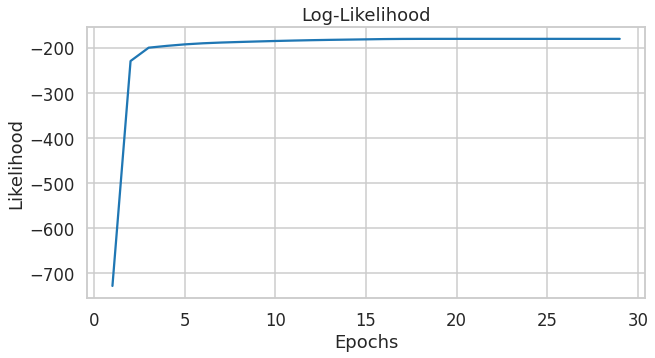

In [15]:
plt.figure(figsize=(10, 5))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, len(likelihoods) + 1), likelihoods)
plt.xlabel("Epochs")
plt.ylabel("Likelihood")
plt.show()

### **Plotting the Clusters**

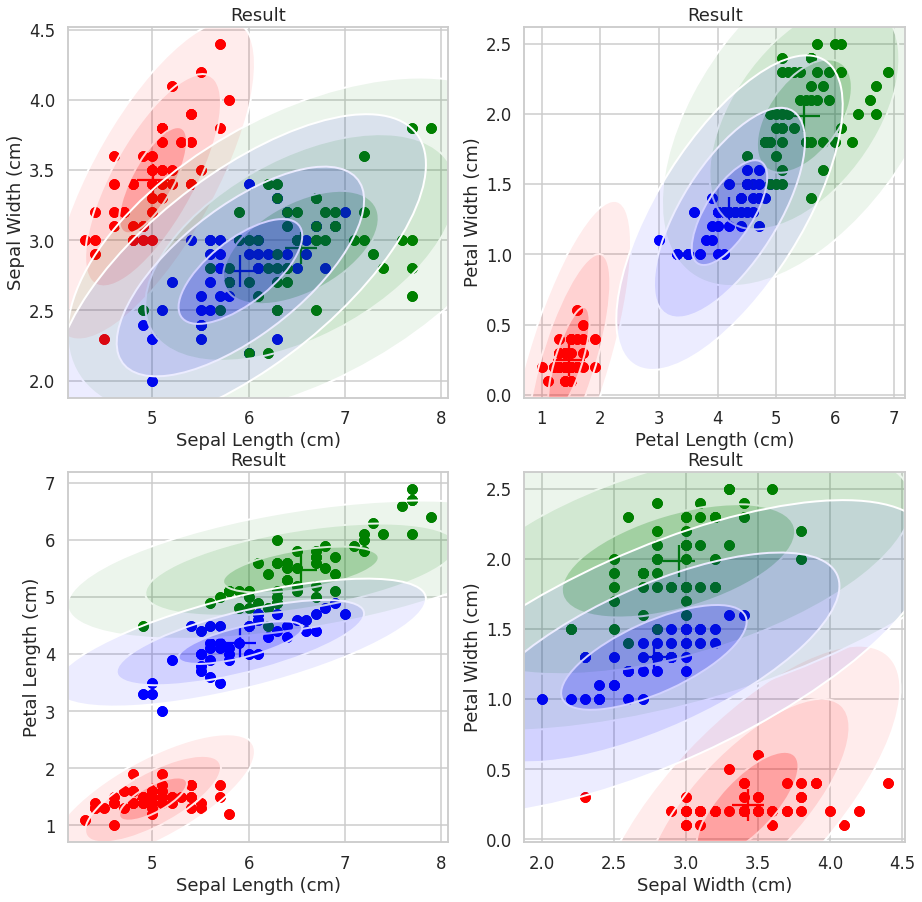

In [17]:
fig, axs = plt.subplots(2,2, figsize=(15, 15), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)

colorset = ['red', 'green', 'blue']
pairs = [(0,1), (2,3),(0,2), (1,3)]
label = ["Sepal Length (cm)", "Sepal Width (cm)", "Petal Length (cm)", "Petal Width (cm)"]


for ax, pair in zip(axs.ravel(), pairs):
    row = pair[0]
    col = pair[1]
    for idx in range(len(clusters)):
      cluster = clusters[idx]
      mu = cluster['mu_k']
      cov = cluster['cov_k']
      eigenvalues, eigenvectors = np.linalg.eigh(cov)
      order = eigenvalues.argsort()[::-1]
      eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
      vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
      theta = np.arctan2(vy, vx)
      color = colors.to_rgba(colorset[idx])
      
      for cov_factor in range(1, 4):
          ell = Ellipse(xy=(cluster['mu_k'][row], cluster['mu_k'][col]), 
                        width=np.sqrt(eigenvalues[0]) * cov_factor * 2, 
                        height=np.sqrt(eigenvalues[1]) * cov_factor * 2, 
                        angle=np.degrees(theta), 
                        linewidth=2)
          ell.set_facecolor((color[0], 
                            color[1], 
                            color[2], 
                            1.0 / (cov_factor * 4.5)))
          ax.add_artist(ell)
      
      ax.scatter(cluster['mu_k'][row], cluster['mu_k'][col], 
                c=colorset[idx], s=1000, marker='+')
      for i in range(X.shape[0]):
          ax.scatter(X[i, row], X[i, col], 
                    c=colorset[np.argmax(scores[i])], 
                    marker='o')
      ax.set_title("Result")
      ax.set_xlabel(label[row])
      ax.set_ylabel(label[col])
    